# Daten Aufbereitung mit:
- create_heatmap zum Heatmap erzeugen aus den json Dateien 
- create_dataset zum Erstellen der Datasets aus Bild und zugehöriger Heatmap als Label und ggf. Augmentierung

In [232]:
import tensorflow as tf
import numpy as np
import json
import random
import os
from scipy.ndimage import gaussian_filter
from keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# --- Hilfsfunktion 1: Heatmap-Generierung ---
def generate_heatmap(corners, image_size, sigma=0.5):
    """
    Erzeugt eine Heatmap mit einem Gauß um einen Punkt.
    :param image_size: Tuple der Form (Höhe, Breite)
    :param point: Tuple (x, y) der Punktkoordinaten
    :param sigma: Standardabweichung für den Gauß
    :return: Heatmap (Höhe x Breite)
    """
    # Heatmap initialisieren
    heatmap = np.zeros(image_size, dtype=np.float32)
    
    # Setze den Punkt in der Heatmap
    for corner in corners:
         # Überprüfe Grenzwerte, um Fehler zu vermeiden
        corner[0] = min(max(corner[0], 0), image_size[1] - 1)  # Breite
        corner[1] = min(max(corner[1], 0), image_size[0] - 1)  # Höhe

        heatmap[corner[1], corner[0]] = 1  # Beachte (y, x)-Reihenfolge
    

    # Gaußfilter anwenden
    return gaussian_filter(heatmap, sigma=sigma)

# --- Hilfsfunktion 2: JSON-Labels parsen ---
def parse_json(json_path):
    """
    Liest die Ecken aus einer JSON-Datei.
    :param json_path: Pfad zur JSON-Datei
    :return: Liste der Punkte [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
        polygon_points=data["shapes"][0]["points"]
        
    return [(int(pt[0]), int(pt[1])) for pt in polygon_points]

# --- Hilfsfunktion 3: Bild- und Label-Laden ---
def load_data(image_path, json_path, image_size=(96,144), scale=0.2):
    """
    Lädt ein Bild und erzeugt Heatmaps für die Ecken.
    :param image_path: Pfad zum Bild
    :param json_path: Pfad zur JSON-Datei
    :param image_size: Zielgröße für die Bilder (Höhe, Breite)
    :return: Bild und Heatmaps als Tensoren
    """
    
    # Bild laden und skalieren
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    #print((int(image_size[0]*scale),int(image_size[1]*scale)))
    image = tf.image.resize(image, image_size)
    #image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normierung

    # Labels (Heatmaps) erstellen
    corners = np.array(parse_json(json_path.numpy().decode()))
    for corner in corners:
       corner[0] *= scale
       corner[1] *= scale
       
    
    heatmaps = generate_heatmap(corners,image_size) 
    return image, heatmaps


# --- Dataset-Erstellung ---
def create_dataset(image_dir, json_dir, batch_size=2, image_size=(96, 144), scale=0.2, shuffle=True):
    """
    Erstellt ein tf.data.Dataset für Bilder und Heatmaps mit Augmentierung.
    :param image_dir: Verzeichnis mit Bildern
    :param json_dir: Verzeichnis mit JSON-Dateien
    :param batch_size: Batch-Größe
    :param image_size: Zielgröße der Bilder
    :param shuffle: Ob die Daten vor dem Batchen gemischt werden sollen
    :return: tf.data.Dataset
    """
    # Pfade zu Bildern und JSON-Dateien sammeln
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    json_paths = sorted([os.path.join(json_dir, fname) for fname in os.listdir(json_dir)])

    # Dataset mit Pfaden erstellen
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, json_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)

    # Prozessierungsfunktion definieren
    def process_paths(image_path, json_path):
        image, heatmaps = tf.py_function(
            func=load_data,
            inp=[image_path, json_path, image_size, scale],
            Tout=(tf.float32, tf.float32)
        )
        image.set_shape([96, 144,3])  # Setze die erwartete Form für das Bild
        heatmaps.set_shape([96, 144])  # Anzahl der Ecken (Anzahl der Kanäle)
        return image, heatmaps

    dataset = dataset.map(process_paths, num_parallel_calls=tf.data.AUTOTUNE)

    # Augmentierungsfunktion anwenden
    def augment(image, heatmaps):
        heatmaps = tf.expand_dims(heatmaps, axis=-1)
        # Zufällige Winkel (auf beide anwenden)
        angle_rad = tf.random.uniform(shape=[], minval=0, maxval=360, dtype=tf.float32) * (3.14159 / 180)

        image = tfa.image.rotate(image, angle_rad)  # Rotation um 90 Grad
        heatmaps = tfa.image.rotate(heatmaps, angle_rad)  # Die gleiche Rotation auf die Heatmap anwenden

        # Zufälliger Seed für den Flip
        seed= random.randint(1, 10000)
        # Zufälliger horizontaler Flip für das Bild und die Heatmap gleichzeitig
        image = tf.image.stateless_random_flip_left_right(image, seed=(seed, 0))
        heatmaps = tf.image.stateless_random_flip_left_right(heatmaps, seed=(seed,0))
        
        # image = tf.image.resize_with_crop_or_pad(image, target_height=96, target_width=144)
        # heatmaps = tf.image.resize_with_crop_or_pad(heatmaps, target_height=96, target_width=144)  # Gleiche Größe wie das Bild

        # Zurück auf die ursprüngliche Größe (optional)
        image = tf.image.resize(image, (96, 144))  # Bild auf die ursprüngliche Größe zurückskalieren
        heatmaps = tf.image.resize(heatmaps, (96, 144))  # Heatmap ebenfalls auf die ursprüngliche Größe zurückskalieren

        return image, heatmaps

    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Erstellen der einzelnen Datasets und bsp. Ausgabe für:
- Test Dataset mit 100 Bildrn zum Testen des Netzes und der implementierten Funktionen
- Trainings Dataset zum tatsächlichen trainieren der Modellparametern
- Validierungs Dataset zum Validierung des Modells 

2025-01-06 11:15:49.234883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [14321]
	 [[{{node Placeholder/_1}}]]
2025-01-06 11:15:49.235138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14321]
	 [[{{node Placeholder/_0}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0360806].


(8, 96, 144, 3)


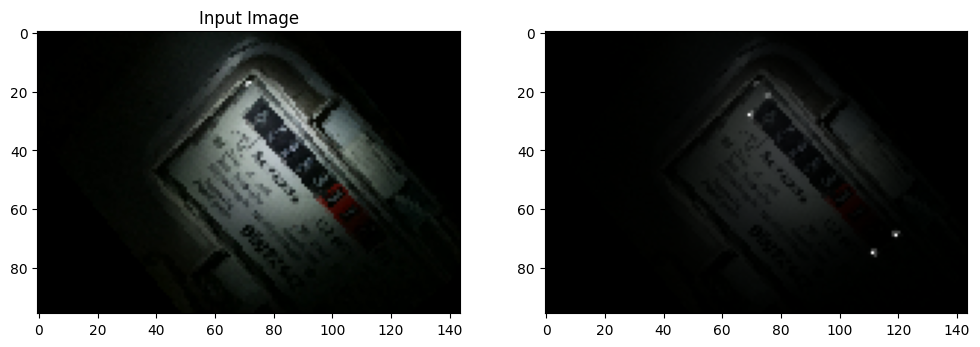

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0090218].


(8, 96, 144, 3)


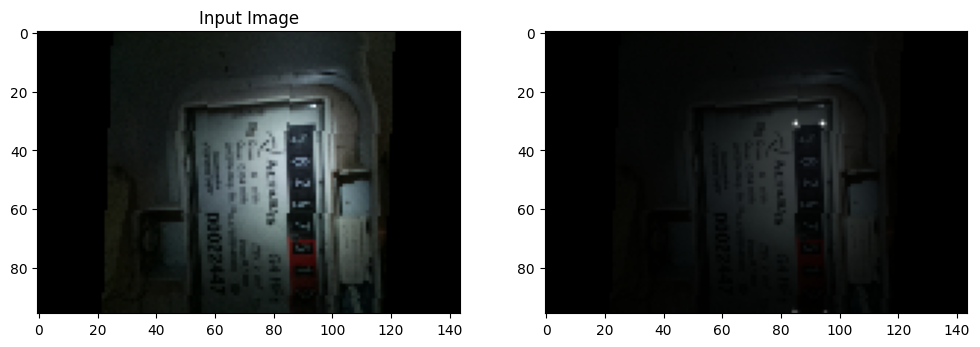

In [233]:
# Verzeichnisse für die 100 test bilder in variablen speichern
#test_image_dir = '/home/leonard/gas/gas_images/images'
#test_json_dir = '/home/leonard/gas/gas_images/labels'

# Verzeichnisse für die 14000 test bilder in variablen speichern
train_image_dir = "/home/leonard/gas/gas_images/images"
train_json_dir = "/home/leonard/gas/gas_images/labels"

#  # Verzeichnisse für die 100 validierungs bilder in variablen speichern
validation_image_dir = '/home/leonard/gas/gas_images/validation_images'
validation_json_dir = '/home/leonard/gas/gas_images/validation_labels'

# Dataset erstellen für test datensatz mit 100 bildern
#test_dataset = create_dataset(test_image_dir, test_json_dir, batch_size=16, shuffle=True)

 # Dataset erstellen für training datensatz mit 14000 bildern
train_dataset = create_dataset(train_image_dir, train_json_dir, batch_size=8, shuffle=True)

# Dataset erstellen für validierung datensatz mit 100 bildern
validation_dataset = create_dataset(validation_image_dir, validation_json_dir, batch_size=8, shuffle=True)


# Iteriere durch das Dataset
for batch_num, (images, heatmaps) in enumerate(train_dataset):
    # Nimm das erste Bild aus dem Batch (z. B. das erste Bild und Heatmap)
    image = images[0].numpy()  # Wandeln Sie Tensor in NumPy-Array um
    heatmap = heatmaps[0].numpy()  # Wandeln Sie Tensor in NumPy-Array um
    print(images.shape)
    
    # # Visualisierung des Bildes und der Heatmap
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Bild anzeigen
    axes[0].imshow(image)  # Bild anzeigen
    axes[0].set_title('Input Image')
    axes[0].axis('on')  # Achsen ausblenden
    
    # Heatmap anzeigen
    #axes[1].imshow(image.squeeze()*0+heatmap.sum(axis=2)[:,:,np.newaxis], cmap='inferno')
    axes[1].imshow(image.squeeze()*0.3+heatmap.sum(axis=2)[:,:,np.newaxis]*3, cmap='hot')
    # axes[1].imshow(heatmap, cmap='hot')
    #axes[1].imshow(heatmap[:, :, 0], cmap='hot')  # Heatmap anzeigen (Nehme die erste Heatmap aus den Kanälen)
    # axes[1].set_title('Heatmap')
    # axes[1].axis('on')  # Achsen ausblenden

    # Zeige das Bild und die Heatmap
    plt.show()
    if batch_num==1:
        break

# Ertellen der Callback Funktion mit:
- Earlystopping zum frühzeitigen trainingsabbruch falls validation loss sich nicht bessert
- reduce_lr zum reduzieren der lernrate falls validation loss sich nicht bessert
- TensorBoard Callback zum protokollieren des Trainings 
- Definition der start_tensorbord funktion

In [234]:
import subprocess

def create_callback(log_dir='./logs', patience_early_stopping=10, patience_lr=10):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience_early_stopping,
        restore_best_weights=True,  # Setzt die besten Gewichte zurück
        verbose=1
    )

    # ReduceLROnPlateau Callback (Reduziert die Lernrate, wenn sich der Validierungsverlust nicht verbessert)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,  # Lernrate wird um den Faktor 0.1 reduziert
        patience=patience_lr,  # Wie viele Epochen warten, bevor die Lernrate reduziert wird
        verbose=1
    )

    # TensorBoard Callback (Protokolliert das Training für TensorBoard)
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,  # Protokolliert Histogramme für die Gewichtsinformationen
        update_freq='epoch'  # Protokolliert die Metriken nach jeder Epoche
    )

    # Alle Callbacks in einer Liste zusammenfassen
    return [early_stopping, reduce_lr, tensorboard]

my_callbacks=create_callback()

# TensorBoard über subprocess starten
def start_tensorboard(log_dir):
    command = f"tensorboard --logdir={log_dir}"
    subprocess.Popen(command, shell=True)

# Erstellen des CNN 
- Defieneren der Netz Struktur

In [187]:
# Beispielmodell
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal

def unet_for_heatmaps(input_size=(None, None, 3), num_classes=1):
    inputs = layers.Input(input_size)

    # Encoder: Downsampling (Contracting Path)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    

    # Decoder: Upsampling (Expanding Path)
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=-1)  # Sicherstellung durch gleichmäßige Dimensionen
    

    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    
    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u7)
    u8 = layers.concatenate([u8, c2], axis=-1)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # Output layer: Mehrkanalige Heatmap-Ausgabe
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(c9)

    model = models.Model(inputs, outputs)
    # inputs = layers.Input(input_size)

    # # Encoder: Downsampling (Contracting Path)
    # c1 = layers.Conv2D(16, (3, 3), padding='same', kernel_initializer=HeNormal())(inputs)  # He-Initialisierung
    # c1 = layers.BatchNormalization()(c1)
    # c1 = layers.Activation('relu')(c1)
    # c1 = layers.Conv2D(16, (3, 3), padding='same', kernel_initializer=HeNormal())(c1)  # He-Initialisierung
    # c1 = layers.BatchNormalization()(c1)
    # c1 = layers.Activation('relu')(c1)
    # p1 = layers.MaxPooling2D((2, 2))(c1)

    # c2 = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=HeNormal())(p1)  # He-Initialisierung
    # c2 = layers.BatchNormalization()(c2)
    # c2 = layers.Activation('relu')(c2)
    # c2 = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=HeNormal())(c2)  # He-Initialisierung
    # c2 = layers.BatchNormalization()(c2)
    # c2 = layers.Activation('relu')(c2)
    # p2 = layers.MaxPooling2D((2, 2))(c2)

    # c3 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal())(p2)  # He-Initialisierung
    # c3 = layers.BatchNormalization()(c3)
    # c3 = layers.Activation('relu')(c3)
    # c3 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal())(c3)  # He-Initialisierung
    # c3 = layers.BatchNormalization()(c3)
    # c3 = layers.Activation('relu')(c3)
    # p3 = layers.MaxPooling2D((2, 2))(c3)

    # c4 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal())(p3)  # He-Initialisierung
    # c4 = layers.BatchNormalization()(c4)
    # c4 = layers.Activation('relu')(c4)
    # c4 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal())(c4)  # He-Initialisierung
    # c4 = layers.BatchNormalization()(c4)
    # c4 = layers.Activation('relu')(c4)
    # p4 = layers.MaxPooling2D((2, 2))(c4)

    # # Bottleneck
    # c5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer=HeNormal())(p4)  # He-Initialisierung
    # c5 = layers.BatchNormalization()(c5)
    # c5 = layers.Activation('relu')(c5)
    # c5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer=HeNormal())(c5)  # He-Initialisierung
    # c5 = layers.BatchNormalization()(c5)
    # c5 = layers.Activation('relu')(c5)

    # # Decoder: Upsampling (Expanding Path)
    # u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=HeNormal())(c5)  # He-Initialisierung
    # u6 = layers.concatenate([u6, c4])
    # c6 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal())(u6)  # He-Initialisierung
    # c6 = layers.BatchNormalization()(c6)
    # c6 = layers.Activation('relu')(c6)
    # c6 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal())(c6)  # He-Initialisierung
    # c6 = layers.BatchNormalization()(c6)
    # c6 = layers.Activation('relu')(c6)

    # u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    # u7 = layers.concatenate([u7, c3])
    # c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    # c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    # u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    # u8 = layers.concatenate([u8, c2])
    # c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    # c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    # u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    # u9 = layers.concatenate([u9, c1])
    # c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    # c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # layers.Resizing(480, 720) #resizing

    # # Output layer: Mehrkanalige Heatmap-Ausgabe
    # outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(c9)

    # model = models.Model(inputs, outputs)

    return model

# Erstellen des Modells 
- Compielieren, zsm.fassen, trainieren
- tensorboard mit start_tensorbord funktion starten

In [224]:
# Modell erstellen
model = unet_for_heatmaps()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Modell kompilieren
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mse'])
# Modell zusammenfassen
model.summary()

# Trainiere das Modell
model.fit(train_dataset, epochs=1000, verbose=1, callbacks=my_callbacks, validation_data=validation_dataset)  # Passe die Anzahl der Epochen nach Bedarf an


# Starte TensorBoard
log_dir='./logs'
start_tensorboard(log_dir)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_265 (Conv2D)            (None, None, None,   448         ['input_22[0][0]']               
                                16)                                                               
                                                                                                  
 max_pooling2d_74 (MaxPooling2D  (None, None, None,   0          ['conv2d_265[0][0]']             
 )                              16)                                                        

2025-01-06 03:15:47.341475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2025-01-06 03:15:47.341705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [100]
	 [[{{node Placeholder/_1}}]]


1791/1791 [==============================] - 284s 155ms/step - loss: 0.0128 - mse: 0.0033 - val_loss: 0.0021 - val_mse: 2.0194e-05 - lr: 1.0000e-04
Epoch 2/1000
1791/1791 [==============================] - 272s 152ms/step - loss: 0.0017 - mse: 1.9799e-05 - val_loss: 0.0020 - val_mse: 2.0614e-05 - lr: 1.0000e-04
Epoch 3/1000
1791/1791 [==============================] - 272s 152ms/step - loss: 0.0015 - mse: 1.8619e-05 - val_loss: 0.0024 - val_mse: 1.9999e-05 - lr: 1.0000e-04
Epoch 4/1000
1791/1791 [==============================] - 272s 152ms/step - loss: 0.0014 - mse: 1.6758e-05 - val_loss: 0.0020 - val_mse: 1.9485e-05 - lr: 1.0000e-04
Epoch 5/1000
1791/1791 [==============================] - 272s 152ms/step - loss: 0.0013 - mse: 1.3876e-05 - val_loss: 0.0022 - val_mse: 2.0342e-05 - lr: 1.0000e-04
Epoch 6/1000
1791/1791 [==============================] - 272s 152ms/step - loss: 0.0012 - mse: 1.1069e-05 - val_loss: 0.0023 - val_mse: 2.0139e-05 - lr: 1.0000e-04
Epoch 7/1000
1791/1791 [===

[2025-01-06T02:43:08Z WARN  rustboard_core::run] Read error in ./logs/train/events.out.tfevents.1734880834.yoga-pro-7.101173.10.v2: ReadRecordError(BadLengthCrc(ChecksumError { got: MaskedCrc(0x07980329), want: MaskedCrc(0x00000000) }))

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.


# Browserzugriff auf TensorBoard:
- Nachdem du TensorBoard gestartet hast, öffne einfach deinen Webbrowser und gehe zu http://localhost:6006, um die TensorBoard-Oberfläche anzuzeigen.

# Test Augmentierung durch manuelle Bildmanipulation
- kann erstmal vernachlässigt werden, da die Heatmaps auf einem Kanal erstellt werden so dass die bereits vorhandenen Augmentierungsfunktion aus Tensorflow genutzt werden können

In [88]:
# # Iteriere durch das Dataset
# for batch_num, (images, heatmaps) in enumerate(test_dataset):
   
#     images = images.numpy()
#     images[0,30:,:,:] = images[0,:-30,:,:]
#      # Nimm das erste Bild aus dem Batch (z. B. das erste Bild und Heatmap)
#     image = images[0]  # Wandeln Sie Tensor in NumPy-Array um
    
#     heatmap = model.predict(tf.convert_to_tensor(images))[0] # Wandeln Sie Tensor in NumPy-Array um
#     print(images.shape)
    
#     # # Visualisierung des Bildes und der Heatmap
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
#     # Bild anzeigen
#     axes[0].imshow(image)  # Bild anzeigen
#     axes[0].set_title('Input Image')
#     axes[0].axis('on')  # Achsen ausblenden
    
#     # Heatmap anzeigen
#     #axes[1].imshow(image.squeeze()*0.1+heatmap.sum(axis=2)[:,:,np.newaxis], cmap='hot')
#     #axes[1].imshow(heatmap.sum(axis=2)[:,:,np.newaxis], cmap='hot')

#     axes[1].imshow(heatmap[:,:,0]+heatmap[:,:,1]+heatmap[:,:,2]+heatmap[:,:,3], cmap='hot')
#     #axes[1].imshow(heatmap[:, :, 0], cmap='hot')  # Heatmap anzeigen (Nehme die erste Heatmap aus den Kanälen)
#     axes[1].set_title('Heatmap')
#     axes[1].axis('off')  # Achsen ausblenden

#     # Zeige das Bild und die Heatmap
#     plt.show()
#     break
    

# Speichern der Netzparameter und der Struktur in Datei "trainiertes_modell.h5"

In [238]:
#speichern des trainierten modells mit allen parasmetern
model.save('modell.h5')

# Laden der zuvor gespeicherten Modellparameter in das Netz 

In [21]:
#gespeichertes modell laden
model = tf.keras.models.load_model('modell.h5')

In [236]:
model.fit(train_dataset, epochs=20, verbose=1, callbacks=my_callbacks)

Epoch 1/20
1791/1791 [==============================] - 272s 152ms/step - loss: 9.2410e-04 - mse: 7.8246e-05 - lr: 1.0000e-04
Epoch 2/20
1791/1791 [==============================] - 271s 151ms/step - loss: 8.8079e-04 - mse: 7.3273e-05 - lr: 1.0000e-04
Epoch 3/20
1791/1791 [==============================] - 272s 152ms/step - loss: 8.5968e-04 - mse: 7.0832e-05 - lr: 1.0000e-04
Epoch 4/20
1791/1791 [==============================] - 271s 151ms/step - loss: 8.4490e-04 - mse: 6.8960e-05 - lr: 1.0000e-04
Epoch 5/20
1791/1791 [==============================] - 272s 152ms/step - loss: 8.4094e-04 - mse: 6.8233e-05 - lr: 1.0000e-04
Epoch 6/20
1791/1791 [==============================] - 273s 153ms/step - loss: 8.2883e-04 - mse: 6.6684e-05 - lr: 1.0000e-04
Epoch 7/20
 866/1791 [=============>................] - ETA: 2:22 - loss: 8.2209e-04 - mse: 6.5791e-05

KeyboardInterrupt: 

# Vergleich von Bild mit Heatmap und Prediction

(8, 96, 144, 3)


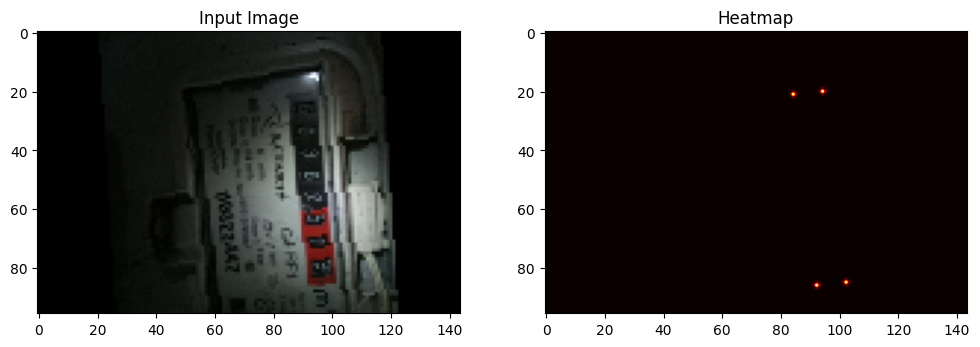

1/1 [==============================] - 0s 71ms/step


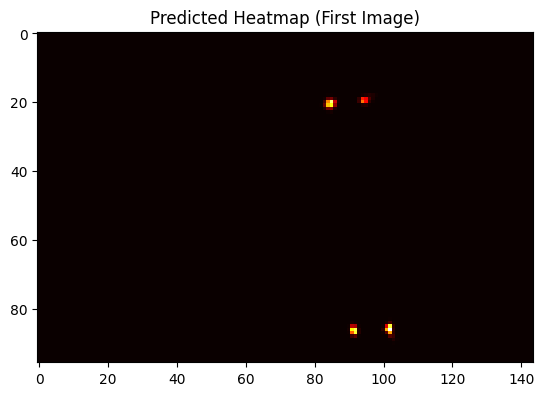

Das sind die Punkte aus der Prediction (array([85, 86, 20, 86]), array([102,  92,  85, 102]), array([0, 0, 0, 0]))
Das sind die sortierten Punkte aus der Prediction 
 [(85, 20), (92, 86), (102, 85), (102, 86)]
Das sind die Punkte aus dem Label (array([86, 85, 20, 21]), array([ 92, 102,  94,  84]), array([0, 0, 0, 0]))
Das sind die sortierten Punkte aus dem Label 
 [(84, 21), (92, 86), (94, 20), (102, 85)]


In [237]:
import numpy
for batch_num, (images, heatmaps) in enumerate(train_dataset):
    # Nimm das erste Bild aus dem Batch (z. B. das erste Bild und Heatmap)
    image = images[0].numpy()
    heatmap = heatmaps[0].numpy()  # Wandeln Sie Tensor in NumPy-Array um

    print(images.shape)
    
    # # Visualisierung des Bildes und der Heatmap
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Bild anzeigen
    axes[0].imshow(image)  # Bild anzeigen
    axes[0].set_title('Input Image')
    axes[0].axis('on')  # Achsen ausblenden
    
    # Heatmap anzeigen
    #axes[1].imshow(image.squeeze()*0.1+heatmap.sum(axis=2)[:,:,np.newaxis], cmap='hot')
    #axes[1].imshow(heatmap.sum(axis=2)[:,:,np.newaxis], cmap='hot')
    axes[1].imshow(heatmap, cmap='hot')
    #axes[1].imshow(heatmap[:, :, 0], cmap='hot')  # Heatmap anzeigen (Nehme die erste Heatmap aus den Kanälen)
    axes[1].set_title('Heatmap')
    axes[1].axis('on')  # Achsen ausblenden

    # Zeige das Bild und die Heatmap
    plt.show()
    prediction = model.predict(images)
    prediction=prediction[0]
    prediction_image = prediction[ :, :, :]

    # Visualisieren des ersten Bildes als Heatmap
    plt.imshow(prediction_image, cmap='hot', interpolation='nearest')
    plt.title("Predicted Heatmap (First Image)")
    plt.show()

    # Anzahl der Punkte definieren
    number_of_points = 4

    top_4_points = np.unravel_index(np.argsort(prediction, axis=None)[-number_of_points:], prediction.shape)
    print('Das sind die Punkte aus der Prediction',top_4_points)
    top_4_points=list(zip(top_4_points[1], top_4_points[0]))
    # Sortieren der Liste nach den x-Werten
    top_4_points = sorted(top_4_points, key=lambda pair: pair[0])
    print('Das sind die sortierten Punkte aus der Prediction \n',top_4_points)

    
    heatmappoints = np.unravel_index(np.argsort(heatmap, axis=None)[-number_of_points:], heatmap.shape)
    print('Das sind die Punkte aus dem Label',heatmappoints)
    heatmappoints=list(zip(heatmappoints[1], heatmappoints[0]))
    # Sortieren der Liste nach den x-Werten
    heatmappoints = sorted(heatmappoints, key=lambda pair: pair[0])
    print('Das sind die sortierten Punkte aus dem Label \n',heatmappoints)

    
    break  # Wandeln Sie Tensor in NumPy-Array um
    


   

# Finden der 4 höchsten Punkte der Heatmap 


In [93]:
# Anzahl der Punkte definieren
number_of_points = 4

#prediction heatmap erstellen für den 1 punkt aus validation dataset
prediction = model.predict(validation_dataset, batch_size=1, verbose=1, steps=1)
prediction=prediction[0]


top_4_points = np.unravel_index(np.argsort(prediction, axis=None)[-number_of_points:], prediction.shape)
print(top_4_points)
top_4_points=list(zip(top_4_points[0], top_4_points[1]))
# Sortieren der Liste nach den x-Werten
top_4_points = sorted(top_4_points, key=lambda pair: pair[0])
print(top_4_points)



1/1 [==============================] - 0s 177ms/step
(array([35, 44, 39, 47]), array([111, 111,  51,  51]), array([0, 0, 0, 0]))
[(35, 111), (39, 51), (44, 111), (47, 51)]
